In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
os.chdir("..")
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from utils.script_utils import obtain_data, obtain_data_cval
from utils.train_script import use_ml_models, use_dl_no_val

from derma.sol.stratification.utils.utils import (
                    stratify_survival_prediction, plot_mean_survival_curves, 
                    plot_calibration_curve, plot_calibration_curve, plot_calibration_curve_km,
                    plot_time_auc, plot_survival_roc_curve)
from derma.sol.stratification.utils.calibration import survival_probability_calibration

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [2]:
_,_,data, labels = obtain_data_cval(dl=False)
_,_, data_dl, labels_dl = obtain_data_cval(dl=True)

deep_copy_data= copy.deepcopy(data)
data_dh= copy.deepcopy(data)
labels_dh = copy.deepcopy(labels_dl)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Train models

In [3]:
### Create hyperparams
class ArgsDict:
    def __init__(self, params_dict):
        self.params_dict = params_dict
        
    def __getattr__(self, name):
        if name in self.params_dict:
            return self.params_dict[name]
        else:
            raise AttributeError(f"'ArgsDict' object has no attribute '{name}'")
            
args_rsf = {
    "min_child_weight": 1,    "num_boost_round": 100,
    "gamma": 0.001,    "alpha": 0.0001,
    "n_estimators": 400,    "max_depth": 11,
    "min_samples_split": 25,    "max_features": "auto",
    "model": "rsf"
}
args_cox= {
    "model": "cox"
}

args_ds = {
    "dropout_prob": 0.4, "lr": 0.005, "reg": 0.0001,
    "num_layers": 3,    "num_nodes": 256,
    "batch_norm": False,    "output_bias": True,
    "model": "deepsurv", "verbose" : False,
    "bs" : 512, "epochs":50,
}

args_dh = {
    "dropout_prob": 0.5, "lr": 0.01, "reg": 1e-05, "num_durations": 30,
    "num_layers": 3,    "num_nodes": 128,
    "batch_norm": True,    "output_bias": False,
    "model": "deephit", "verbose" : False,
    "bs" : 256, "epochs":80,
}

# Obtain "ArgParser"
args_cox = ArgsDict(args_cox)
args_rsf = ArgsDict(args_rsf)
args_ds = ArgsDict(args_ds)
args_dh = ArgsDict(args_dh)

In [15]:
# Train cox model
cox_cindex, cox_brier, cox_model = use_ml_models(data, labels, args_cox)
cox_cindex

0.7873594433922011

In [5]:
# Train deepsurv model
rsf_cindex, rsf_brier, rsf_model = use_ml_models(data, labels, args_rsf)
rsf_cindex

0.7981636642199245

In [6]:
# Train the DeepSurv model
ds_cindex, ds_brier, log_ds, ds_model = use_dl_no_val(data_dl, labels_dl, args_ds)
ds_cindex

Could not log loss
C-index: 0.7939,  IBS: 0.1222


0.7939297137213696

In [7]:
# Train the DeepHit model
dh_cindex, dh_brier, log_dh, dh_model = use_dl_no_val(data_dh, labels_dh, args_dh)
dh_cindex

Could not log loss
C-index: 0.8014,  IBS: 0.1361


0.8013921669507565

In [11]:
dh_model.duration_index

array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.,
        77.,  84.,  91.,  98., 105., 112., 119., 126., 133., 140., 147.,
       154., 161., 168., 175., 182., 189., 196., 203.])

/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=12 is not in the output_times of the model we will use the closest value which is 14.
  index = np.abs(output_times - t0).argmin()
/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=36 is not in the output_times of the model we will use the closest value which is 35.
  index = np.abs(output_times - t0).argmin()
/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=60 is not in the output_times of the model we will use the closest value which is 63.
  index = np.abs(output_times - t0).argmin()


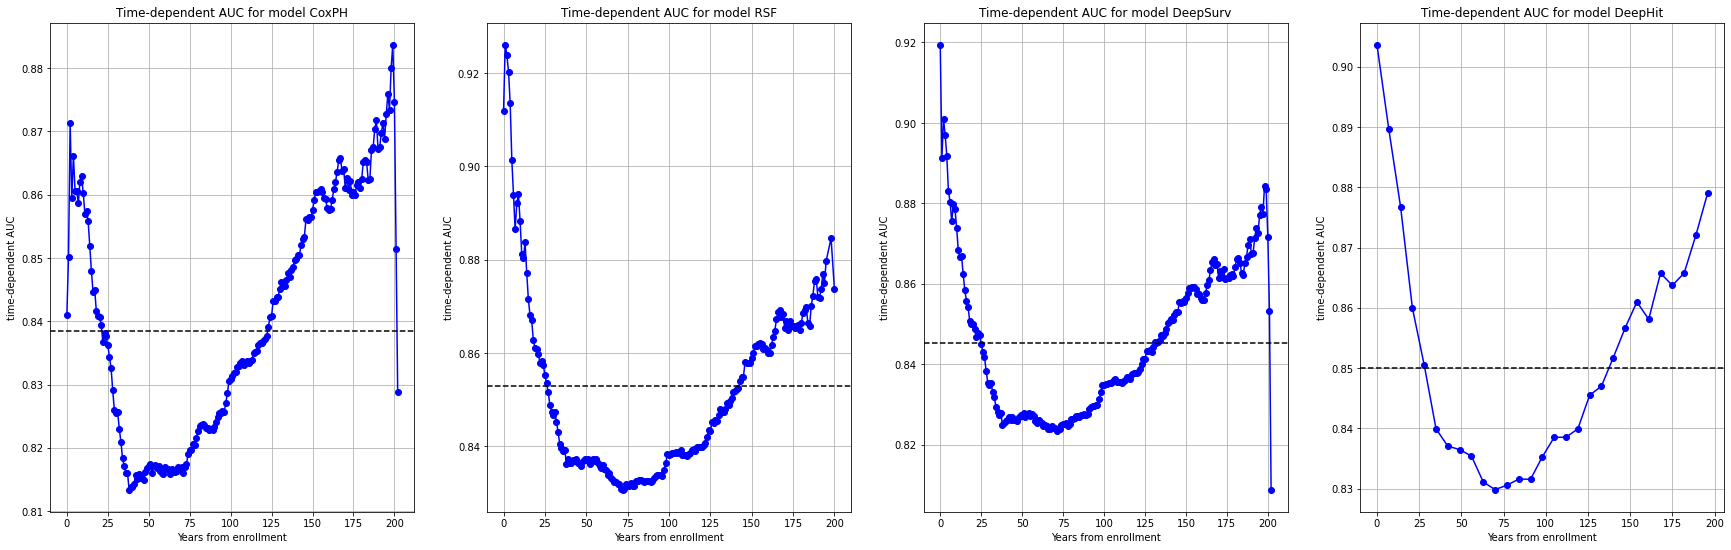

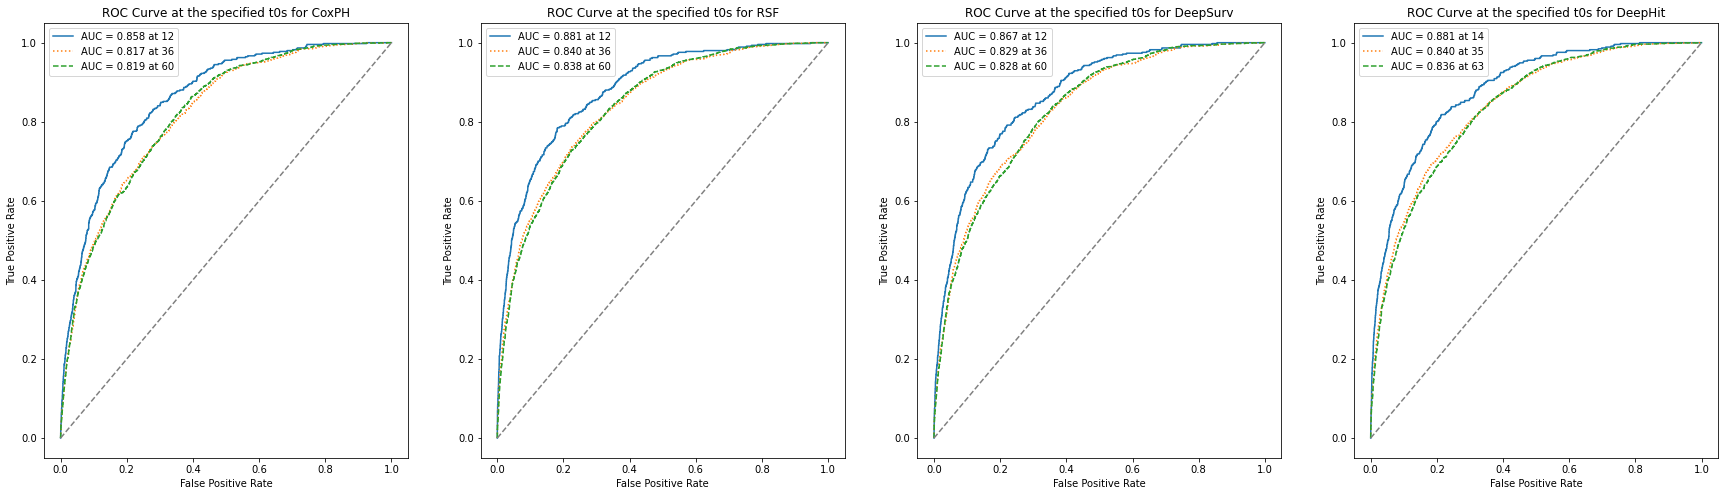

In [24]:
#deep_copy_data = copy.deepcopy(data)
train_times = [x[1] for x in labels[0]]
train_events = [x[0] for x in labels[0]]

test_times = [x[1] for x in labels[1]]
test_events = [x[0] for x in labels[1]]


train_df = pd.DataFrame({'event': train_events, 'duration': train_times})
test_df = pd.DataFrame({'event': test_events, 'duration': test_times})



fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 9), gridspec_kw={'hspace': 0.5})
fig_2, axs_2 = plt.subplots(nrows=1, ncols=4, figsize=(30, 9), gridspec_kw={'hspace': 0.5})
#fig_3, axs_3 = plt.subplots(nrows=1, ncols=4, figsize=(23, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.2})

X_train = deep_copy_data[0]
X_test = deep_copy_data[1]


for i, model in enumerate([cox_model, rsf_model, ds_model, dh_model]):
    ax = axs[i]
    ax_2 = axs_2[i]
 #   ax_3 = axs_3[i]
    plot_time_auc(model, X_test, train_df, test_df, ax=ax)
    plot_survival_roc_curve(model, X_test, test_df, times_plot = [12,12*3,12*5], ax=ax_2)
  #  plot_calibration_curve(model, X_test, test_df, [5], ax=ax_3)
  #  _ = survival_probability_calibration(model, X_test, test_df, 60, ax=ax_3)

save_path = f'/home/carlos.hernandez/PhD/xai-healthcare/Figures/'


# Create a two by two matrix instead of 4x2 

/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=12 is not in the output_times of the model we will use the closest value which is 14.
  index = np.abs(output_times - t0).argmin()
/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=36 is not in the output_times of the model we will use the closest value which is 35.
  index = np.abs(output_times - t0).argmin()
/home/carlos.hernandez/PhD/marato-derma/derma/sol/stratification/utils/utils.py:553: UserWarning: 
t0=60 is not in the output_times of the model we will use the closest value which is 63.
  index = np.abs(output_times - t0).argmin()


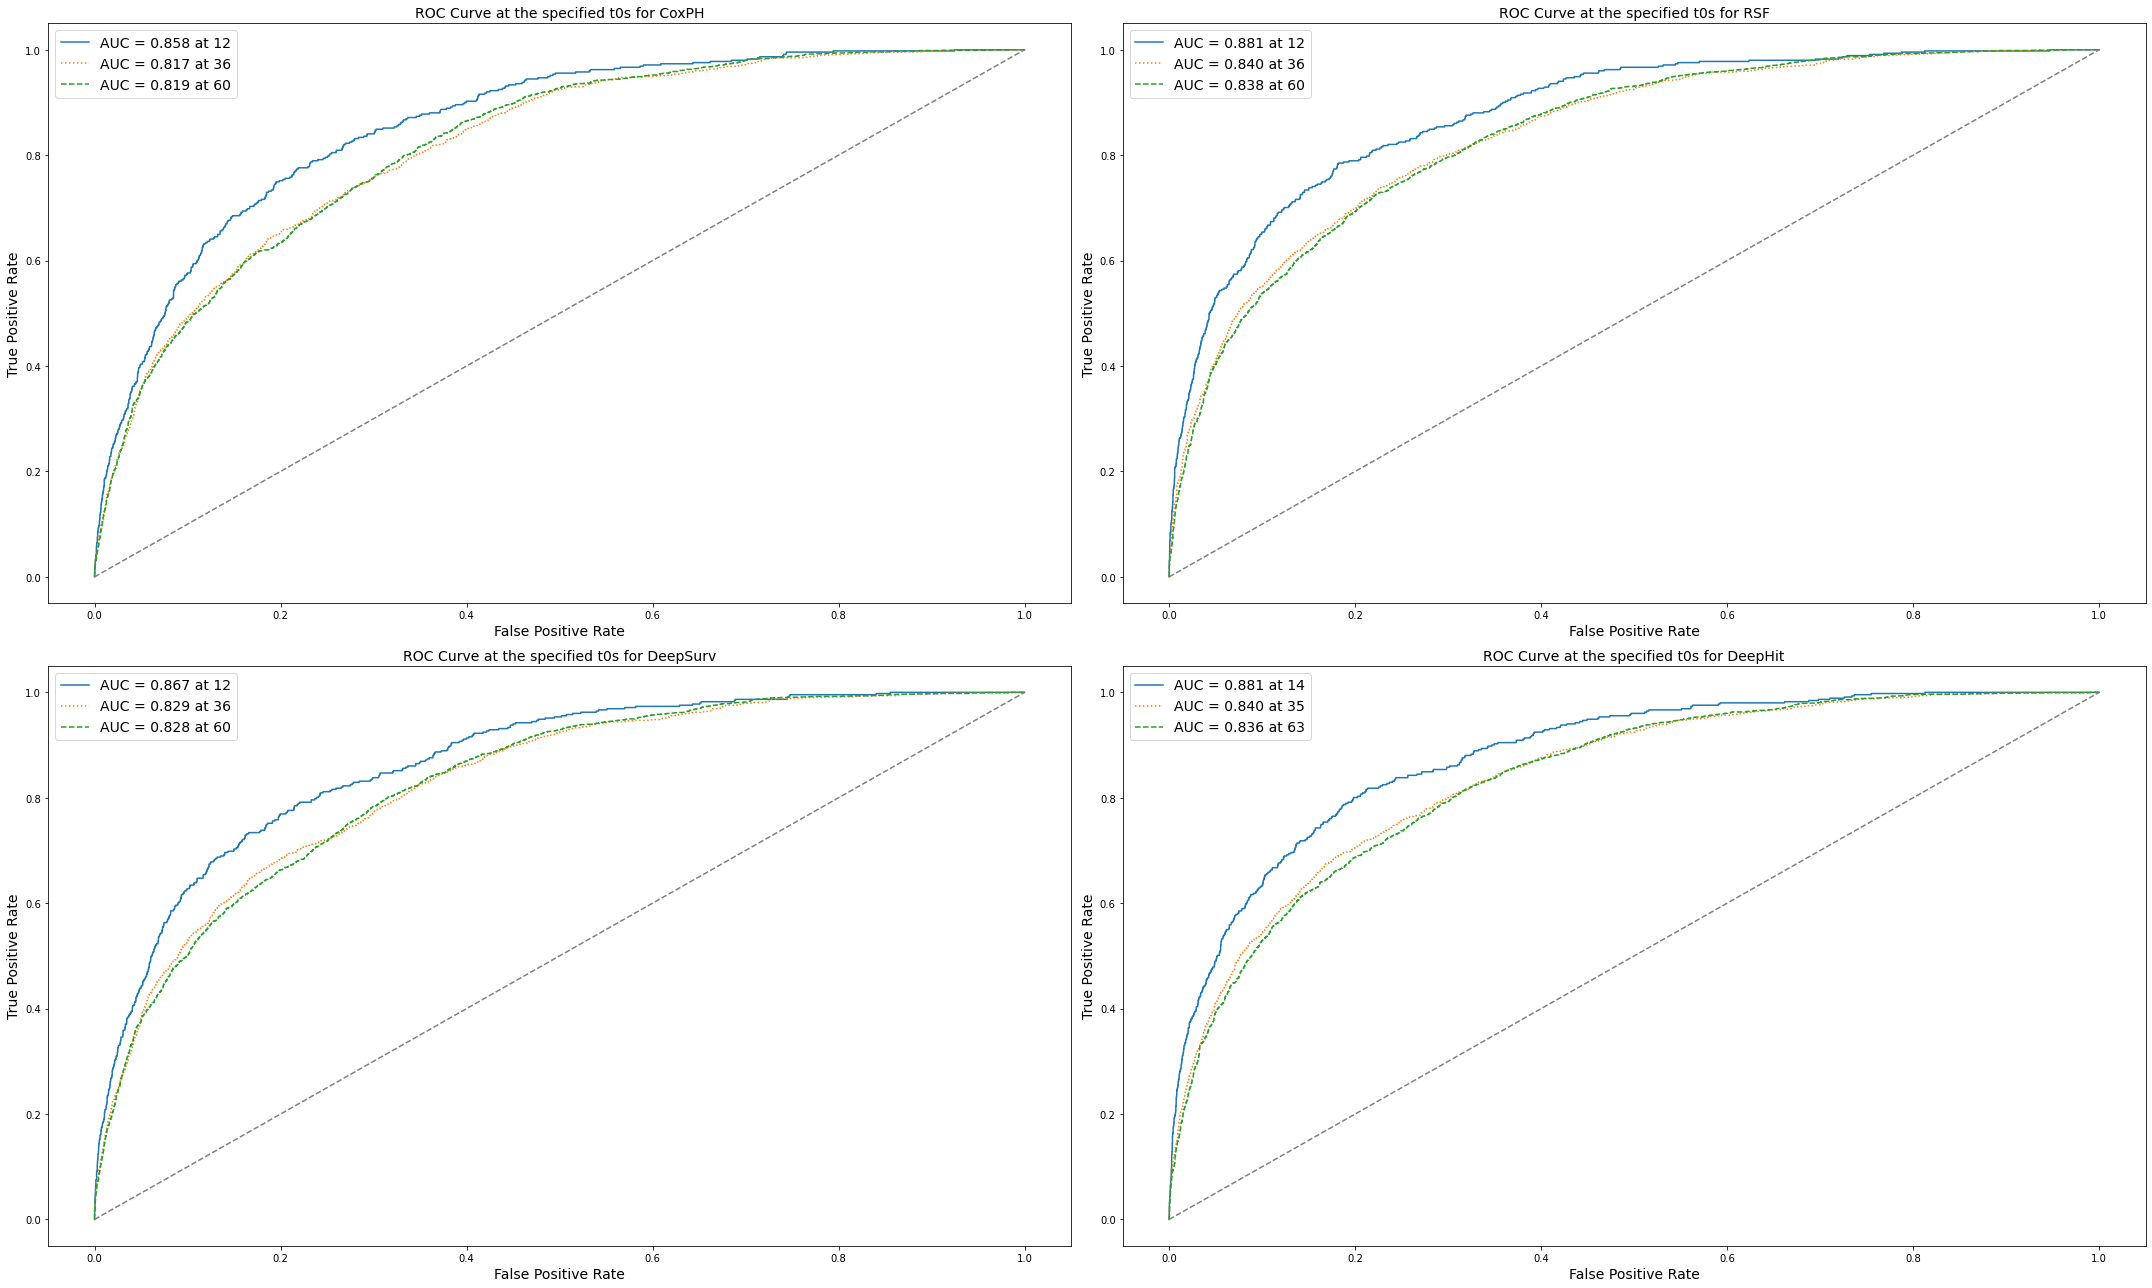

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))

for i, (ml_model, dl_model) in enumerate(zip([cox_model, rsf_model], [ds_model, dh_model])):
    row_index = i // 2
    col_index = i % 2
    ax = axs[row_index][col_index]
    ax_2 = axs[row_index+1][col_index]

    plot_survival_roc_curve(ml_model, X_test, test_df, times_plot = [12,12*3,12*5], ax=ax)
    plot_survival_roc_curve(dl_model, X_test, test_df, times_plot = [12,12*3,12*5], ax=ax_2)
    
fig.tight_layout()
plt.show()

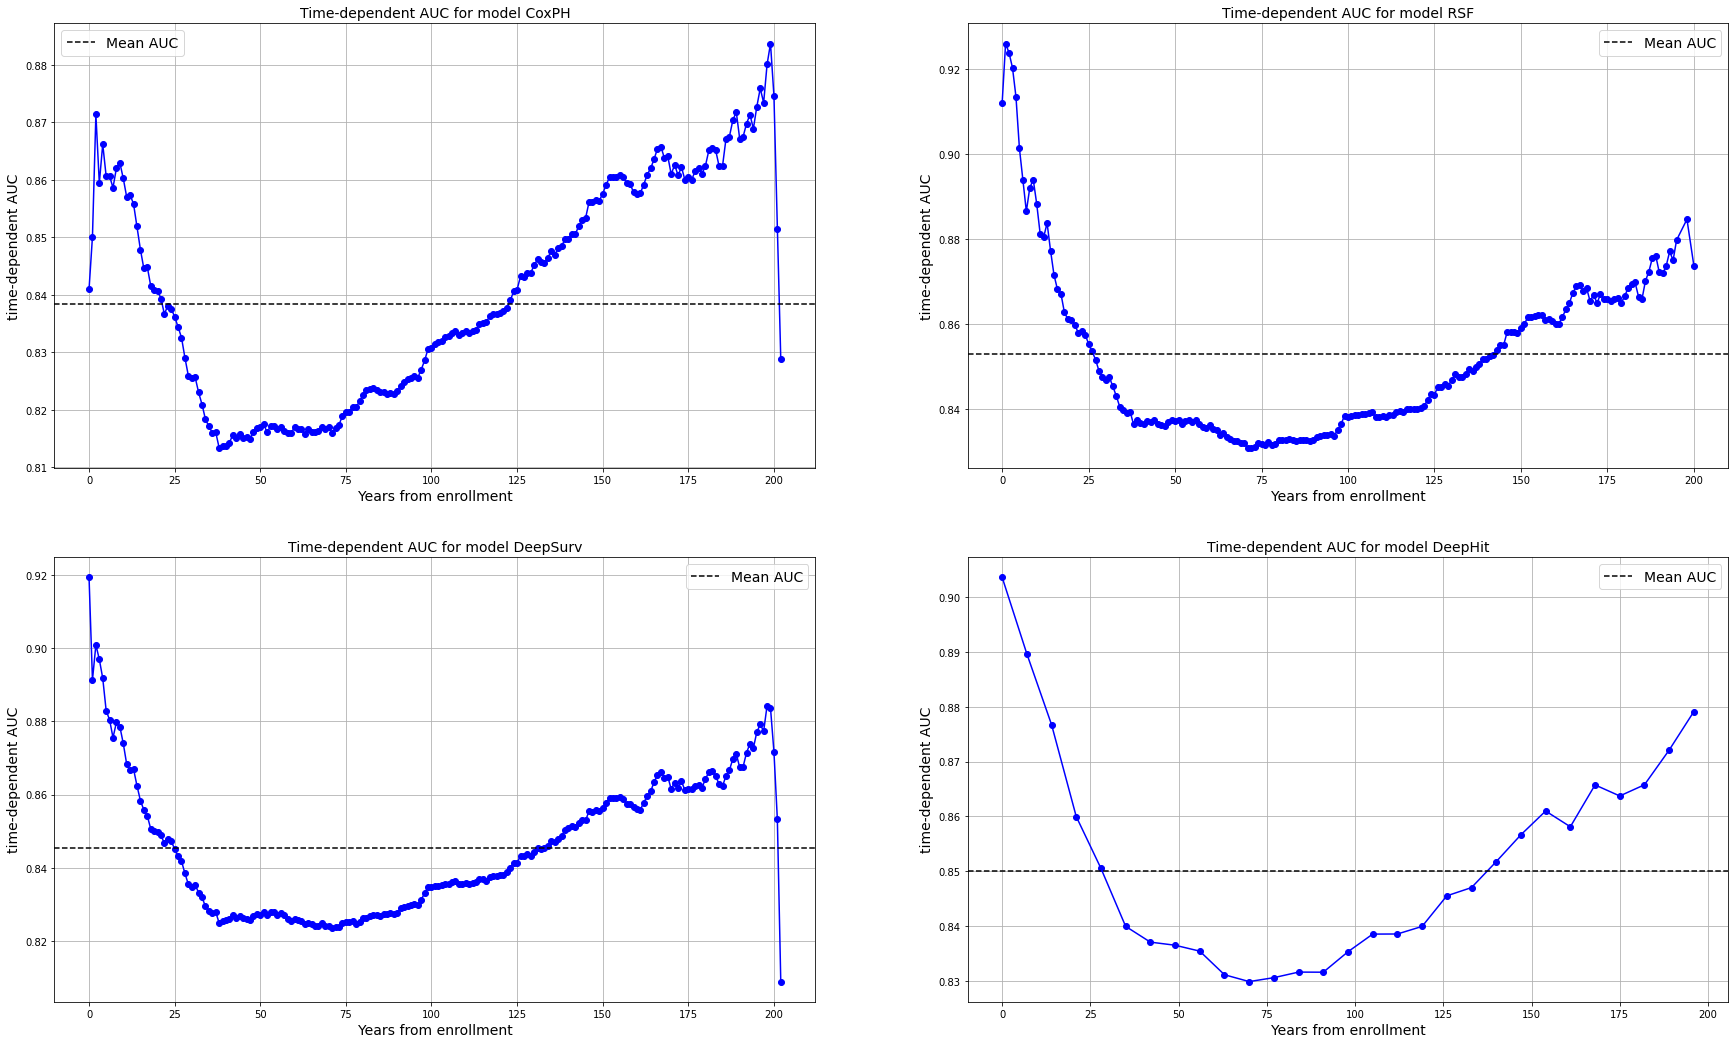

In [36]:
fig_new, axs_new = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))

for i, (ml_model, dl_model) in enumerate(zip([cox_model, rsf_model], [ds_model, dh_model])):
    row_index = i // 2
    col_index = i % 2
    ax = axs_new[row_index][col_index]
    ax_2 = axs_new[row_index+1][col_index]
    plot_time_auc(ml_model, X_test, train_df, test_df, ax=ax)
    plot_time_auc(dl_model, X_test, train_df, test_df, ax=ax_2)

    #  plot_calibration_curve(model, X_test, test_df, [5], ax=ax_3)
  #  _ = survival_probability_calibration(model, X_test, test_df, 60, ax=ax_3)


In [37]:
fig_new.savefig(save_path +'time_auc_plots.png', bbox_inches='tight', dpi=300)
fig.savefig(save_path +'roc_auc_plots.png', bbox_inches='tight', dpi=300)